# Data Exploration

In [88]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import xgboost as xgb
from catboost import CatBoostRegressor

from scipy.special import boxcox1p, inv_boxcox1p
from scipy import stats
from scipy.stats import norm, skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [4]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.05
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

In [5]:
bc_dataframe

,periodo,id_cli,edad,genero,estado_civil,nivel_academico,ocupacion,tipo_vivienda,ult_actual,categoria,...,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,201902,2586604,46,F,CAS,UNIVERSITARIO,Independiente,\N,20180810,1,...,140000.00000,0.00000,0,4263513.10000,H,NApl,N,0.00000,0.00000,1355030.00000
1,201902,3898166,43,M,NI,BACHILLER,Comerciante,\N,20180912,4,...,0.00000,0.00000,0,1030200.00000,NApl,incumple,N,0.00000,0.00000,6447.00000
2,201902,3530319,44,F,SOL,SIN INFORMACION,Empleado,\N,20181018,1,...,136754000.00000,0.00000,8,1545690.00000,E,cumple,N,0.00000,0.00000,733965.99000
3,201902,6637866,33,F,UL,SIN INFORMACION,Empleado,\N,20190108,1,...,60000.00000,0.00000,2,1714450.00000,H,NApl,N,0.00000,0.00000,526861.24000
4,201902,2903203,30,F,SOL,UNIVERSITARIO,Empleado,\N,20180712,2,...,116646000.00000,0.00000,6,3354389.10000,A,cumple,S,5853732.00000,0.00000,264580.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55519,202011,6065464,24,F,CAS,SIN INFORMACION,Empleado,\N,20200304,1,...,41000.00000,0.00000,2,350855.00000,A,cumple,N,1188902.00000,1113000.00000,225353.00000
55520,202011,2061236,43,F,SOL,UNIVERSITARIO,Empleado,\N,20200622,2,...,0.00000,0.00000,1,3601550.39000,A,cumple,N,0.00000,0.00000,2942929.00000
55521,202011,4768846,49,F,SOL,UNIVERSITARIO,Empleado,\N,20200519,1,...,0.00000,0.00000,0,-90696.81000,D,incumple,N,0.00000,0.00000,191993.53000
55522,202011,2076800,25,M,CAS,UNIVERSITARIO,Empleado,\N,20200518,1,...,139000.00000,0.00000,3,458450.00000,C,NApl,N,0.00000,0.00000,340971.00000


In [15]:
pct_spending=len(bc_dataframe[(bc_dataframe['gasto_familiar'] < 10000000) &
             (bc_dataframe['gasto_familiar'] >= 50000)]['gasto_familiar']) / len(bc_dataframe)
print(f"Porcentaje de personas con gastos familiares entre 50000 y 10 millones: {pct_spending}")

Porcentaje de personas con gastos familiares entre 50000 y 10 millones: 0.8978223465093832


# Preprocessing class

In [98]:
class DataFramePreProcessor:
    
    def __init__(self, dataframe, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None
    
    
    def handleMissingData(self, dataframe):
        dataframe['ingreso_final'] = dataframe['ingreso_final'].fillna(0)
        dataframe['ind'] = dataframe['ind'].fillna(0)
        return dataframe
    
    # Borrar filas deacuerdo a cierta logica de negocio
    def rowFilter(self, dataframe):
        return dataframe[
            #(dataframe['edad'] < 100) & # Imputar a percentil 99
            (dataframe['gasto_familiar'] >= 50000) &
            #(dataframe['edad'] >=20) &
            (dataframe['gasto_familiar'] < 30000000) &
            # (dataframe['cant_oblig_tot_sf'] < 13) &
            (dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
            (dataframe['ingreso_final'] < 50000000) &
            (dataframe['cuota_cred_hipot'] >= 0) &
            (dataframe['tiene_ctas_activas'] == 0)
        ] 
    
    def oneEncodeVariables(self):
        pass
    
    def newVars(self, dataframe):
        pct_vars = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            'cupo_total_tc',
            'cupo_tc_mdo'
        ]
        
        cat_vars = [
            'mora_max', # Tal vez haya que encontrar el umbral correcto
            'estado_civil',
            'rep_calif_cred',
            'ocupacion',
            'tipo_vivienda'
           # 'nivel_academico'
            # 'pol_centr_ext' # En test no existen personas con cero
        ]
        
        dataframe['edad'] = np.where(dataframe['edad'] < 18, 18,
                                    np.where(dataframe['edad'] > 80, 80, dataframe['edad']
                                    ))
        
        #dataframe['categoria']=np.where(dataframe['categoria']=='\\N', "6",dataframe['categoria'])
        #dataframe['categoria']=dataframe['categoria'].astype(float).astype(int)
        
        if not self.test:
            dataframe['ajuste_2020'] = dataframe['periodo'].apply(lambda x: 0.9 if str(x)[:4] == '2020' else 1)
            dataframe['gasto_familiar_ajustado'] = dataframe['gasto_familiar'] * dataframe['ajuste_2020']
            numeric_feats = dataframe.drop(['gasto_familiar', 'gasto_familiar_ajustado'], axis=1).dtypes[
                    (dataframe.dtypes == "float64")].index

        else:
             numeric_feats = dataframe.dtypes[
                    (dataframe.dtypes == "float64")].index
        skewed_feats = dataframe[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        skewness = pd.DataFrame({'Skew' :skewed_feats})
        skewness = skewness[abs(skewness) > 0.75]


        skewed_features = skewness.index
        lam = 0.15
        for feat in skewed_features:
            dataframe[feat] = boxcox1p(dataframe[feat], lam)
        
        dummified = []
        for var in cat_vars:
            dummified.append(
                pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
            )
        
        dummified = pd.concat(dummified, axis=1)
        dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)
        for var in pct_vars:
            dataframe[f"{var}_pct"] = dataframe[var] / dataframe['ingreso_final'] 
            dataframe[f"{var}_pct"] = dataframe[f"{var}_pct"].replace(dict.fromkeys([np.nan, np.inf], 0))
            
        for var in pct_vars:
            dataframe[f"{var}_log"] = np.log1p(dataframe[var])
 
        dataframe['genero'] = np.where(dataframe['genero'] == 'M', 0, 1)
        dataframe['ind_mora_vigente'] = np.where(dataframe['ind_mora_vigente'] == "S", 1, 0)
        dataframe['convenio_lib'] = np.where(dataframe['convenio_lib'] == 'S', 1, 0)
        dataframe['ingreso_calculado'] =  dataframe['ingreso_segurida_social']  +  \
                                          dataframe[['ingreso_nompen', 'ingreso_nomina']].max(axis=1) 
        dataframe['ind_annio'] = dataframe['periodo'].apply(lambda x: 1 if str(x)[:4] == '2020' else 0)
        dataframe['ind_covid'] = np.where(
            dataframe['periodo'].isin([202004,202003,202005]), 1,0)
        if not self.test:
            # dataframe['gasto_familiar'] = np.where(dataframe['gasto_familiar'] < 0, 0, dataframe['gasto_familiar'])
            dataframe['log_gasto_familiar'] = np.log(dataframe['gasto_familiar'] +1 ) 
            dataframe['log_gasto_familiar_ajustado'] = np.log1p(dataframe['gasto_familiar_ajustado'])
            
        dataframe['ingreso_final'] = np.log(dataframe['ingreso_final']+1)
        dataframe['cupo_total_tc'] = np.log(dataframe['cupo_total_tc']+1)
        dataframe['ingreso_nomina'] = np.log(dataframe['ingreso_nomina']+1)
        dataframe['ingreso_segurida_social'] = np.log(dataframe['ingreso_segurida_social']+1)
        dataframe['ingreso_nompen'] = np.log(dataframe['ingreso_nompen']+1)
        dataframe['ingreso_calculado'] = np.log(dataframe['ingreso_calculado']+1)
     

    
    
        dataframe['obl_total_pct'] = dataframe['cuota_cred_hipot_pct'] + \
                                     dataframe['cuota_tarjeta_de_credito_pct'] +\
                                     dataframe['cuota_de_consumo_pct'] + \
                                     dataframe['cuota_rotativos_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] + \
                                     dataframe['cuota_de_sector_solidario_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] 
                                    
        dataframe['total_cuota'] = dataframe['cuota_cred_hipot'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_de_consumo'] + \
                                   dataframe['cuota_rotativos'] + \
                                   dataframe['cuota_de_sector_solidario'] + \
                                   dataframe['cuota_libranza_sf'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_tc_bancolombia']
        
        dataframe['total_cupo'] = dataframe['cupo_total_tc'] + dataframe['cupo_tc_mdo']
                                
        dataframe['ingreso_corr'] = dataframe[['ingreso_final', 'ingreso_calculado']].max(axis=1)
        dataframe['ingreso_corr_log'] = np.log(dataframe['ingreso_corr']+1)
        
        dataframe['interact_ing_gen']  = dataframe['genero'] * dataframe['ingreso_corr']
        dataframe['interact_ing_ed']  = dataframe['edad'] * dataframe['ingreso_corr']
        dataframe['interact_cup_gen']  = dataframe['genero'] * dataframe['cupo_total_tc']
        dataframe['interact_cup_ed']  = dataframe['edad'] * dataframe['cupo_total_tc']
        dataframe['interact_obl_gen'] = dataframe['genero'] * dataframe['obl_total_pct']
        dataframe['interact_obl_ed']  = dataframe['edad'] * dataframe['obl_total_pct']
        
        dataframe['ingreso_cero'] = np.where(dataframe['ingreso_corr'] == 0, 1, 0)
        dataframe['ingreso_geo_alto']  = np.where(dataframe['ingreso_corr'] < 14.90, 1, 0) # ALgo mas tecnico
        dataframe['es_ciudad_principal'] = np.where(
            dataframe['departamento_residencia'].isin(['BOGOTA D.C.', 'ANTIOQUIA', 'VALLE', 'CUNDINAMARCA']), 1,0)
        
        dataframe['pc25'] = np.where(dataframe['ingreso_corr'] <= np.quantile(dataframe['ingreso_corr'],0.25), 1, 0)
        dataframe['pc75'] = np.where(dataframe['ingreso_corr'] >= np.quantile(dataframe['ingreso_corr'],0.75), 1, 0)
        
        # variables al cuadrado
        
        dataframe['edad_2'] = dataframe['edad']**2
        dataframe['total_cuota_2']  =dataframe['total_cuota']**2
        dataframe['total_cupo_2']  =dataframe['total_cupo']**2
        dataframe['obl_total_pct_2'] = dataframe['obl_total_pct']**2
        dataframe['ingreso_corr2'] = dataframe['ingreso_corr']**2 
        
        #dataframe['obl_total_pct'] = boxcox1p(dataframe['obl_total_pct'], 0.15)
        #dataframe['cuota_cred_hipot'] = boxcox1p(dataframe['cuota_cred_hipot'], 0.15)
        dataframe['educacion_grupo'] = np.where(
            dataframe['nivel_academico'].isin(['PRIMARIO', 'UNIVERSITARIO', 'ESPECIALIZACION']),1,0
        )
        
        #if not self.test:
        #    dataframe = dataframe[dataframe['ingreso_corr'] != 0]

        return dataframe
    
    def process(self):
        
        complete_df = self.handleMissingData(self.original_dataframe)
        if not self.test:
            filtered_df = self.rowFilter(complete_df)
            grown_df    = self.newVars(filtered_df)
        else:
            grown_df    = self.newVars(complete_df)
        self.modeling_dataframe = grown_df
        
        return self.modeling_dataframe
        

In [361]:
fe_dataframe.modeling_dataframe['cuota_cred_hipot'].describe()

count     10389.00000
mean      63913.21809
std      317298.31302
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max     9803596.38000
Name: cuota_cred_hipot, dtype: float64

In [305]:
fe_dataframe.modeling_dataframe.groupby('es_ciudad_principal')['gasto_familiar'].mean()

es_ciudad_principal
0   1211598.09147
1   1289140.64473
Name: gasto_familiar, dtype: float64

In [22]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)

In [23]:
%time fe_dataframe.process()

Wall time: 8.65 s


,periodo,id_cli,edad,genero,nivel_academico,ult_actual,categoria,ind_mora_vigente,departamento_residencia,cupo_total_tc,...,ingreso_geo_alto,es_ciudad_principal,pc25,pc75,edad_2,total_cuota_2,total_cupo_2,obl_total_pct_2,ingreso_corr2,educacion_grupo
0,201902,2586604,46,1,UNIVERSITARIO,20180810,1,0,MAGDALENA,0.00000,...,1,0,0,0,2116,0.00000,0.00000,0.00000,17.26680,1
2,201902,3530319,44,1,SIN INFORMACION,20181018,1,0,ANTIOQUIA,0.00000,...,1,1,0,0,1936,8654.99863,6377.67773,2.15124,17.47572,0
3,201902,6637866,33,1,SIN INFORMACION,20190108,1,0,BOGOTA D.C.,0.00000,...,1,1,0,0,1089,6710.37342,4400.08273,0.50220,16.59821,0
4,201902,2903203,30,1,UNIVERSITARIO,20180712,2,0,VALLE,4.16342,...,1,1,0,0,900,35402.93215,2695.70646,3.14590,17.82865,1
5,201902,2940893,26,0,UNIVERSITARIO,20181002,1,0,ANTIOQUIA,3.91262,...,1,1,0,0,676,1166.84346,15.30859,0.00000,16.26709,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55519,202011,6065464,24,1,SIN INFORMACION,20200304,1,0,BOGOTA D.C.,4.02171,...,1,1,0,1,576,16338.33125,16.17413,1.70900,20.81679,0
55520,202011,2061236,43,1,UNIVERSITARIO,20200622,2,0,BOGOTA D.C.,4.40245,...,1,1,0,0,1849,15676.47160,19.38153,0.43575,17.12190,1
55521,202011,4768846,49,1,UNIVERSITARIO,20200519,1,0,CAUCA,0.00000,...,1,0,1,0,2401,1176.83614,0.00000,0.99761,12.71058,1
55522,202011,2076800,25,0,UNIVERSITARIO,20200518,1,0,ANTIOQUIA,4.28467,...,1,1,1,0,625,12218.50638,18.35841,0.52719,15.57371,1


In [18]:
fe_dataframe.modeling_dataframe

,periodo,id_cli,edad,genero,nivel_academico,ult_actual,categoria,ind_mora_vigente,departamento_residencia,cupo_total_tc,...,ingreso_geo_alto,es_ciudad_principal,pc25,pc75,edad_2,total_cuota_2,total_cupo_2,obl_total_pct_2,ingreso_corr2,educacion_grupo
0,201902,2586604,46,1,UNIVERSITARIO,20180810,1,0,MAGDALENA,0.00000,...,1,0,0,0,2116,0.00000,0.00000,0.00000,17.26680,1
2,201902,3530319,44,1,SIN INFORMACION,20181018,1,0,ANTIOQUIA,0.00000,...,1,1,0,0,1936,8654.99863,6377.67773,2.15124,17.47572,0
3,201902,6637866,33,1,SIN INFORMACION,20190108,1,0,BOGOTA D.C.,0.00000,...,1,1,0,0,1089,6710.37342,4400.08273,0.50220,16.59821,0
4,201902,2903203,30,1,UNIVERSITARIO,20180712,2,0,VALLE,4.16342,...,1,1,0,0,900,35402.93215,2695.70646,3.14590,17.82865,1
5,201902,2940893,26,0,UNIVERSITARIO,20181002,1,0,ANTIOQUIA,3.91262,...,1,1,0,0,676,1166.84346,15.30859,0.00000,16.26709,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55519,202011,6065464,24,1,SIN INFORMACION,20200304,1,0,BOGOTA D.C.,4.02171,...,1,1,0,1,576,16338.33125,16.17413,1.70900,20.81679,0
55520,202011,2061236,43,1,UNIVERSITARIO,20200622,2,0,BOGOTA D.C.,4.40245,...,1,1,0,0,1849,15676.47160,19.38153,0.43575,17.12190,1
55521,202011,4768846,49,1,UNIVERSITARIO,20200519,1,0,CAUCA,0.00000,...,1,0,1,0,2401,1176.83614,0.00000,0.99761,12.71058,1
55522,202011,2076800,25,0,UNIVERSITARIO,20200518,1,0,ANTIOQUIA,4.28467,...,1,1,1,0,625,12218.50638,18.35841,0.52719,15.57371,1


In [20]:
fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['ingreso_corr'] ==0][['ingreso_corr', 'gasto_familiar']].describe()

,ingreso_corr,gasto_familiar
count,4923.00000,4923.00000
mean,0.00000,1295028.26820
std,0.00000,1946726.33129
min,0.00000,50000.00000
25%,0.00000,335559.42000
50%,0.00000,713605.00000
75%,0.00000,1482848.50000
max,0.00000,29533793.66000


<AxesSubplot:xlabel='ingreso_final', ylabel='Density'>

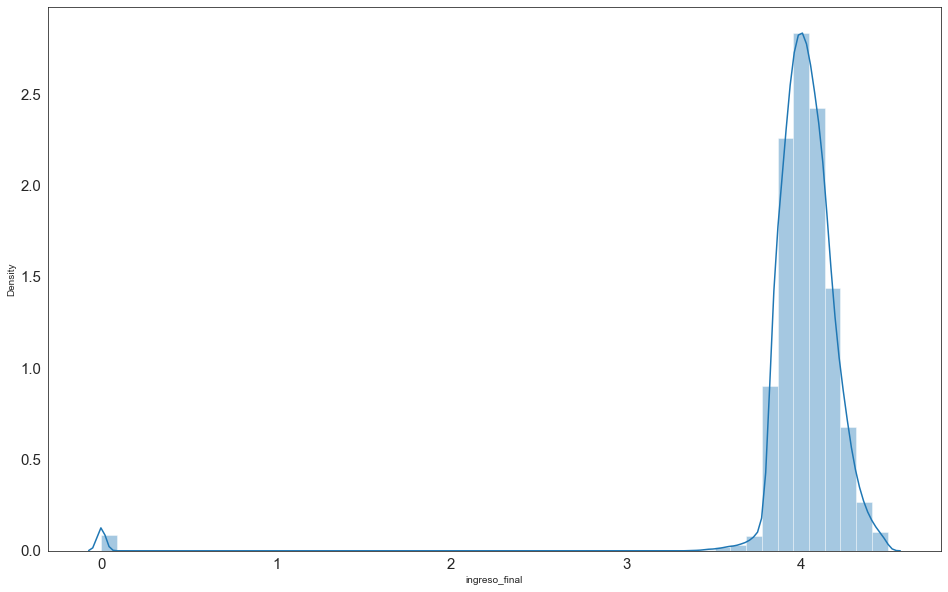

In [16]:
sns.distplot(fe_dataframe.modeling_dataframe['ingreso_final'])

In [302]:
fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['gasto_familiar']< 50000]

,Unnamed: 0,periodo,id_cli,edad,genero,ult_actual,categoria,ind_mora_vigente,departamento_residencia,cupo_total_tc,...,ingreso_corr_log,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,ingreso_cero,ingreso_geo_alto,es_ciudad_principal,pc10,pc90
2,68,201902,4036152,34,0,20180625,1,0,MAGDALENA,0.00000,...,2.73268,0.00000,488.71544,0.00000,0.00000,0,1,0,0,0
7,104,201902,4781182,24,0,20170527,1,0,ANTIOQUIA,0.00000,...,2.77168,0.00000,359.65121,0.00000,0.00000,0,0,1,0,0
44,434,201902,5095698,26,0,20180713,1,0,SANTANDER,15.59046,...,2.81905,0.00000,409.78602,0.00000,405.35204,0,0,0,0,0
45,439,201902,6150134,25,1,20180430,1,0,ATLANTICO,0.00000,...,2.77390,15.02103,375.52586,0.00000,0.00000,0,0,0,0,0
59,586,201902,4799476,26,1,20171202,1,0,ANTIOQUIA,13.91082,...,2.72535,14.26179,370.80649,13.91082,361.68136,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105125,1046012,201902,6032807,20,1,20170916,1,0,ANTIOQUIA,0.00000,...,2.67131,13.45884,269.17674,0.00000,0.00000,0,1,1,1,0
105138,1046132,201902,264169,47,0,20180807,3,0,ATLANTICO,16.67771,...,2.86784,0.00000,780.15128,0.00000,783.85244,0,0,0,0,1
105163,1046381,201902,4647213,25,0,20180506,1,0,QUINDIO,13.81551,...,2.74974,0.00000,365.96521,0.00000,345.38779,0,1,0,0,0
105178,1046552,201902,6058384,30,1,20170823,1,0,BOGOTA D.C.,13.71015,...,2.68929,13.72120,411.63603,13.71015,411.30453,0,1,1,1,0


In [118]:
fe_dataframe.modeling_dataframe['log_gasto_familiar_ajustado'].describe()

count   96672.00000
mean        3.70064
std         0.17437
min         3.22438
25%         3.58711
50%         3.70784
75%         3.81859
max         4.39364
Name: log_gasto_familiar_ajustado, dtype: float64

In [274]:
fe_dataframe.modeling_dataframe[
    (fe_dataframe.modeling_dataframe['genero'] == 0)][['gasto_familiar','ingreso_corr']].corr()

,gasto_familiar,ingreso_corr
gasto_familiar,1.00000,0.13746
ingreso_corr,0.13746,1.00000


In [270]:
(100-22000)/100

-219.0

In [52]:
np.quantile(bc_dataframe.dropna()['ingreso_final'], 0.9)

9311748.6

In [395]:
fe_dataframe.modeling_dataframe[['ingreso_final', 'ingreso_calculado', 'ingreso_corr']].corr()

,ingreso_final,ingreso_calculado,ingreso_corr
ingreso_final,1.00000,0.01813,0.87505
ingreso_calculado,0.01813,1.00000,0.14357
ingreso_corr,0.87505,0.14357,1.00000


In [325]:
fe_dataframe.modeling_dataframe.dtypes

periodo                int64
id_cli                 int64
edad                   int64
genero                 int32
ult_actual             int64
                       ...  
ingreso_cero           int32
ingreso_geo_alto       int32
es_ciudad_principal    int32
pc10                   int32
pc90                   int32
Length: 120, dtype: object

In [357]:
bc_dataframe.select_dtypes("float")

,cupo_total_tc,cuota_tc_bancolombia,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,ingreso_final,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,...,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,ind,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12474,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12460,0.00000,0.00000,139900.00000
1,0.12446,0.12328,0.00000,0.12447,0.00000,0.12447,0.12446,0.00000,0.00000,0.00000,...,0.12409,0.00000,0.00000,0.00000,0.12409,0.00000,0.12370,0.12445,0.00000,63238.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12479,0.00000,0.00000,0.00000,...,0.12387,0.00000,0.00000,0.00000,0.12514,0.00000,0.12455,0.00000,0.00000,602210.00000
5,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12453,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12428,0.00000,0.00000,533500.00000
6,0.12533,0.12427,0.00000,0.00000,0.00000,0.00000,0.12469,0.00000,0.12393,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.12451,0.00000,0.12429,0.00000,0.00000,350900.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104450,0.00000,0.00000,0.00000,0.12455,0.00000,0.12455,0.12461,0.00000,0.12443,0.00000,...,0.12409,0.12470,0.12466,0.12394,0.12523,0.12422,0.12407,0.12455,0.00000,111083.00000
104451,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12466,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.12515,0.00000,0.12447,0.00000,0.00000,119070.00000
104453,0.12517,0.12434,0.00000,0.00000,0.00000,0.00000,0.12482,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12459,0.00000,0.00000,347190.00000
104454,0.00000,0.00000,0.00000,0.12458,0.00000,0.12458,0.12461,0.00000,0.00000,0.00000,...,0.00000,0.12491,0.12317,0.00000,0.00000,0.00000,0.12444,0.12460,0.00000,359169.17000


# Modeling

In [225]:
fe_dataframe.modeling_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103411 entries, 0 to 104014
Columns: 138 entries, Unnamed: 0 to pc90
dtypes: float64(51), int32(9), int64(13), object(5), uint8(60)
memory usage: 64.7+ MB


In [93]:
feature_cols = [
     'ingreso_corr',
  #  'ingreso_final',
  #  'ingreso_calculado',
    'cuota_cred_hipot',
    'cuota_tarjeta_de_credito',
    'cuota_de_consumo',
    'cuota_rotativos',
    'cuota_libranza_sf',
    #'genero',
    'cuota_de_sector_solidario',
    'cuota_sector_real_comercio',
    #'ind_mora_vigente',
    #'ind_annio',
    'cuota_tc_bancolombia',
    'cupo_tc_mdo',
    #'convenio_lib',
    'cant_oblig_tot_sf',
    'edad',
    #'estado_civil_DIV',
    #'estado_civil_NI',
    #'estado_civil_OTRO',
    #'estado_civil_SOL',
    #'estado_civil_UL',
    #'estado_civil_VIU',
    #'nro_tot_cuentas',
    #'ctas_activas',
    'interact_ing_gen',
    'interact_ing_ed',
    'interact_cup_gen',
    'interact_cup_ed',
    'obl_total_pct',
    #'ingreso_cero',
    #'ingreso_geo_alto',
    #'es_ciudad_principal',
    'cupo_total_tc',
    #'ind_covid',
    #'tenencia_tc',
    #'tiene_consumo',
    #'tiene_crediagil',
    #'pc25',
    #'ocupacion_Empleado',
    #'ocupacion_Comerciante',
    #'pc75',
    #'interact_obl_ed',
    #'interact_obl_gen',
    #'categoria',
    'total_cuota_2',
    #'total_cupo_2',
    #'ingreso_corr2',
    #'obl_total_pct_2',
    'educacion_grupo'
]

bc_dataframe = pd.read_csv("train_202003_cleaned.csv",skiprows=lambda i: i>0 and random.random() > 0.1)
bc_dataframe = bc_dataframe[bc_dataframe['gasto_familiar'] >0]
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
X = fe_dataframe.modeling_dataframe[feature_cols]
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']

#scaled_data = scale(X) # promedio de los valores de cada gene debe ser cero con std 1
#pca = PCA()
#pca.fit(scaled_data )# Matemática del PCA
#pca_data = pca.transform(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror', n_estimators=50, random_state=101)
elastic_params ={'alpha': 0.010151733000510865, 'l1_ratio': 0.010077935175737287}
elastic_reg = ElasticNet(**elastic_params)
lasso_reg=Lasso()
ridge_reg=Ridge()
cat_reg = CatBoostRegressor(n_estimators=50)
cat_reg.fit(X_train, y_train, verbose=False)
#model_lgb = lgb.LGBMRegressor(objective='regression')
#model_lgb.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
#svr_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
elastic_reg.fit(X_train, y_train)

ElasticNet(alpha=0.010151733000510865, l1_ratio=0.010077935175737287)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

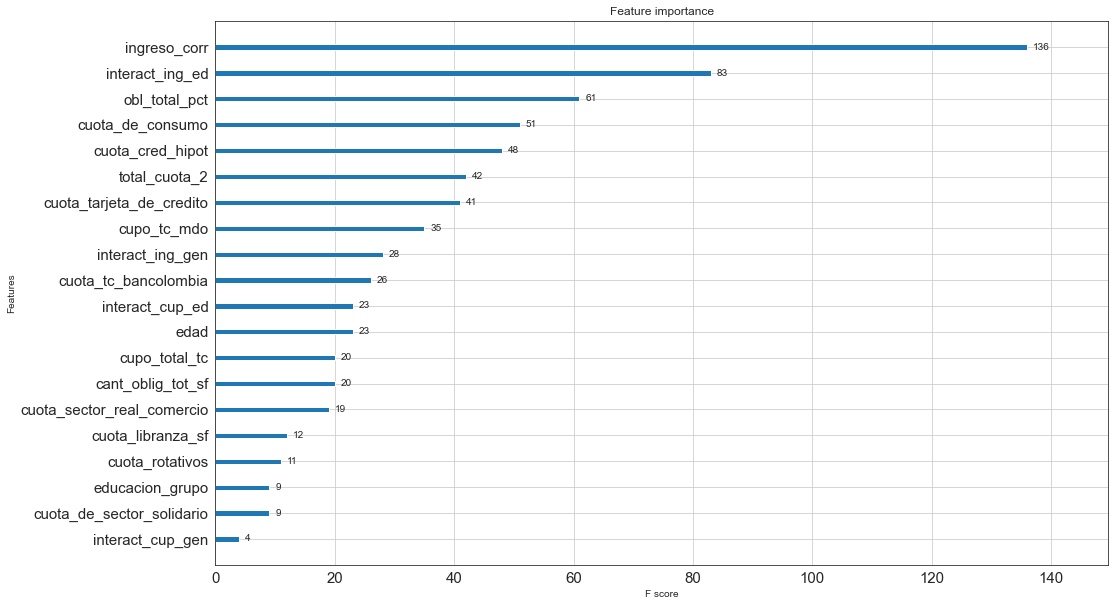

In [94]:
xgb.plot_importance(xgb_reg)

In [97]:
xgb_pred = xgb_reg.predict(X_test)
print("XGBoost: ", mean_absolute_percentage_error(xgb_pred, y_test))

elastic_pred=elastic_reg.predict(X_test)
print("Elastic Net: ", mean_absolute_percentage_error(elastic_pred, y_test))

lasso_pred= lasso_reg.predict(X_test)
print("Lasso: ", mean_absolute_percentage_error(lasso_pred, y_test))
      
ridge_pred=ridge_reg.predict(X_test)
print("Ridge: ", mean_absolute_percentage_error(ridge_pred, y_test))
      
catboost_pred=cat_reg.predict(X_test)
print("Catboost: ", mean_absolute_percentage_error(catboost_pred, y_test))  

ensemble_predictions = xgb_pred*0.3 + elastic_pred*0.1 + lasso_pred*0.1 +ridge_pred*0.2 +catboost_pred*0.3
print("Ensemble: ", mean_absolute_percentage_error(ensemble_predictions, y_test))

XGBoost:  0.054640376221599125
Elastic Net:  0.056223716032046296
Lasso:  0.05822535965385963
Ridge:  0.05614203263263443
Catboost:  0.05462486342237875
Ensemble:  0.05484744095865472


In [62]:
y_pred_train = xgb_reg.predict(X_train)
mean_absolute_percentage_error(y_pred_train, y_train, multioutput='uniform_average')

0.058807748736709554

In [287]:
bc_dataframe['nivel_academico']

0         SIN INFORMACION
1               BACHILLER
2           UNIVERSITARIO
3         SIN INFORMACION
4               TECNOLOGO
               ...       
112607      UNIVERSITARIO
112608         NO INFORMA
112609    ESPECIALIZACION
112610    SIN INFORMACION
112611      UNIVERSITARIO
Name: nivel_academico, Length: 108072, dtype: object

In [281]:
bc_dataframe.groupby('nivel_academico')['gasto_familiar'].mean().sort_values()

nivel_academico
SIN INFORMACION    771706.58089
TECNOLOGO          852810.69478
NO INFORMA         936776.95160
NINGUNO            988041.32274
BACHILLER         1036777.95073
UNIVERSITARIO     1073509.75030
PRIMARIO          1201767.85353
ESPECIALIZACION   1498351.47979
Name: gasto_familiar, dtype: float64

In [276]:
fe_dataframe.modeling_dataframe[[ 'edad_2', 'edad', 'total_cupo',
                                 'total_cuota_2', 'total_cupo_2', 'total_cuota', 'obl_total_pct_2',
                                 'gasto_familiar',
                                 'log_gasto_familiar', 'gasto_familiar_ajustado', 'log_gasto_familiar_ajustado', 'ingreso_corr2']].corr()

,edad_2,edad,total_cupo,total_cuota_2,total_cupo_2,total_cuota,obl_total_pct_2,gasto_familiar,log_gasto_familiar,gasto_familiar_ajustado,log_gasto_familiar_ajustado,ingreso_corr2
edad_2,1.00000,0.98644,0.16381,0.12811,0.20286,0.10501,0.02831,0.05565,0.06639,0.05565,0.06639,-0.00418
edad,0.98644,1.00000,0.18424,0.14695,0.22387,0.12292,0.04388,0.07254,0.08801,0.07254,0.08801,0.01398
total_cupo,0.16381,0.18424,1.00000,0.58288,0.96618,0.66149,0.35565,0.04231,0.06044,0.04231,0.06044,0.17868
total_cuota_2,0.12811,0.14695,0.58288,1.00000,0.62039,0.93506,0.56193,0.15182,0.15136,0.15182,0.15136,0.25552
total_cupo_2,0.20286,0.22387,0.96618,0.62039,1.00000,0.66154,0.34620,0.06630,0.08376,0.06630,0.08376,0.19121
total_cuota,0.10501,0.12292,0.66149,0.93506,0.66154,1.00000,0.54830,0.11504,0.12316,0.11504,0.12316,0.26228
obl_total_pct_2,0.02831,0.04388,0.35565,0.56193,0.34620,0.54830,1.00000,0.03292,0.03726,0.03292,0.03726,0.02905
gasto_familiar,0.05565,0.07254,0.04231,0.15182,0.06630,0.11504,0.03292,1.00000,0.74324,1.00000,0.74324,0.12683
log_gasto_familiar,0.06639,0.08801,0.06044,0.15136,0.08376,0.12316,0.03726,0.74324,1.00000,0.74324,1.00000,0.13956
gasto_familiar_ajustado,0.05565,0.07254,0.04231,0.15182,0.06630,0.11504,0.03292,1.00000,0.74324,1.00000,0.74324,0.12683


# Ensemble Pipeline

In [413]:
test_df['tiene_ctas_activas'].value_counts()

0    281666
Name: tiene_ctas_activas, dtype: int64

In [101]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

last_predictions_list = []
y_tests = []
y_preds = []
mapes   = []
models = []
p = 0.15

random.seed(10)

for date in dates:
    print(f"Periodo {date}:")
    raw_dataframe = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    # raw_dataframe=raw_dataframe[raw_dataframe['gasto_familiar'] >0 ] 
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )
    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    X = fe_dataframe.modeling_dataframe[feature_cols]
    y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

    xgb_params =  {'n_estimators': 120,
                    'max_depth': 12, 'reg_alpha': 2, 
                    'reg_lambda': 7, 'min_child_weight': 5,
                    'gamma': 3, 'learning_rate': 0.1099, 'colsample_bytree': 0.88,
                   'objective': 'reg:squaredlogerror'
                   }
    elastic_params ={'alpha': 0.010151733000510865, 'l1_ratio': 0.010077935175737287}
    xgb_reg = xgb.XGBRegressor(**xgb_params)
    elastic_reg = ElasticNet(**elastic_params)
    lasso_reg=Lasso()
    ridge_reg=Ridge()
    cat_reg = CatBoostRegressor(n_estimators=100)  
    
    xgb_reg.fit(X_train, y_train)
    elastic_reg.fit(X_train, y_train)
    cat_reg.fit(X_train, y_train, verbose=False)
    lasso_reg.fit(X_train, y_train)
    ridge_reg.fit(X_train, y_train)
    
    models.append([xgb_reg, elastic_reg, cat_reg, lasso_reg, ridge_reg])
    xgb_pred = xgb_reg.predict(X_test)
    elastic_pred = elastic_reg.predict(X_test)
    lasso_pred   = lasso_reg.predict(X_test)
    ridge_pred   = ridge_reg.predict(X_test)
    catboost_pred = cat_reg.predict(X_test)
    y_tests.append(y_test)
    y_preds.append([xgb_pred,elastic_pred, lasso_pred, ridge_pred, catboost_pred])
    ensemble_prediction=xgb_pred*0.3 + elastic_pred*0.1 +lasso_pred*0.1 +ridge_pred*0.2 +catboost_pred*0.3
    mape = mean_absolute_percentage_error(ensemble_prediction, y_test)
    mapes.append(mape)
    print(f"     MAPE {date}: ", mape )
    
    month_test = test_df_modeling.modeling_dataframe[test_df_modeling.modeling_dataframe['periodo'] == int(date)].reset_index()
    final_prediction_xgb=np.expm1(xgb_reg.predict(month_test[feature_cols]))
    final_prediction_elastic=np.expm1(elastic_reg.predict(month_test[feature_cols]))
    final_prediction_lasso=np.expm1(lasso_reg.predict(month_test[feature_cols]))
    final_prediction_ridge=np.expm1(ridge_reg.predict(month_test[feature_cols]))
    final_prediction_catboost=np.expm1(cat_reg.predict(month_test[feature_cols]))
    final_prediction = final_prediction_xgb*0.3 + final_prediction_elastic*0.1 + final_prediction_lasso*0.1 + \
                        final_prediction_ridge*0.2 + final_prediction_catboost*0.3

    
    submission = pd.concat([month_test['id_registro'],pd.Series(final_prediction)], axis=1)
    submission.columns = ["id_registro", "gasto_familiar"]
    submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
    submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
    
    last_predictions_list.append(submission)


Periodo 201902:
     Total rows in original_data 156957
     Total rows in transformed_data 129517
     MAPE 201902:  0.06072769535157611
Periodo 201903:
     Total rows in original_data 160719
     Total rows in transformed_data 138422
     MAPE 201903:  0.05995323370205996
Periodo 201904:
     Total rows in original_data 162283
     Total rows in transformed_data 138819
     MAPE 201904:  0.059487357715823495
Periodo 201905:
     Total rows in original_data 163427
     Total rows in transformed_data 143285
     MAPE 201905:  0.059095161965721725
Periodo 201907:
     Total rows in original_data 166032
     Total rows in transformed_data 150000
     MAPE 201907:  0.059265970999487945
Periodo 201908:
     Total rows in original_data 166886
     Total rows in transformed_data 151035
     MAPE 201908:  0.05867764313285913
Periodo 201909:
     Total rows in original_data 166928
     Total rows in transformed_data 151719
     MAPE 201909:  0.0583545162325847
Periodo 201910:
     Total rows 

In [107]:
predictions_list = []
for model in models:
    final_predictions_xgb=np.expm1(model[0].predict(test_df_modeling.modeling_dataframe[feature_cols]))
    final_predictions_elastic=np.expm1(model[1].predict(test_df_modeling.modeling_dataframe[feature_cols]))
    final_predictions_lasso=np.expm1(model[2].predict(test_df_modeling.modeling_dataframe[feature_cols]))
    final_predictions_ridge=np.expm1(model[3].predict(test_df_modeling.modeling_dataframe[feature_cols]))
    final_predictions_catboost=np.expm1(model[4].predict(test_df_modeling.modeling_dataframe[feature_cols]))

    final_prediction=final_predictions_xgb*0.3+final_predictions_elastic*0.1 +final_predictions_lasso*0.1 +\
                       final_predictions_ridge*0.2 + final_predictions_catboost*0.3
    
    predictions_list.append(final_prediction)

In [108]:
stack =  predictions_list[0] +\
predictions_list[1] + \
predictions_list[2] + \
predictions_list[3] + \
predictions_list[4] + \
predictions_list[5] + \
predictions_list[6] + \
predictions_list[7] + \
predictions_list[8] + \
predictions_list[9] + \
predictions_list[10] + \
predictions_list[11] + \
predictions_list[12] + \
predictions_list[13] + \
predictions_list[17] + \
predictions_list[18] 

final_prediction=stack / 19

In [109]:
submission = pd.concat([test_df['id_registro'],pd.Series(final_prediction)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
#submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
submission

,id_registro,gasto_familiar
0,4055#201902,499106.57370
1,12598#201902,382214.77740
2,23697#201902,500013.95870
3,23768#201902,432077.52190
4,7174#201902,564512.36610
...,...,...
281661,8596193#202011,451105.25710
281662,8616083#202011,769593.66650
281663,8670207#202011,2669890.14110
281664,8677655#202011,640598.21160


In [110]:
submission.to_csv("submission_underground.csv", index=False)

In [111]:
np.mean(mapes)

0.05850278779318071

In [148]:
test_df_modeling.modeling_dataframe[test_df_modeling.modeling_dataframe['edad'] >=80]

,id_registro,periodo,id_cli,edad,genero,ult_actual,ind_mora_vigente,departamento_residencia,cupo_total_tc,cuota_tc_bancolombia,...,ingreso_corr_log,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,ingreso_cero,ingreso_geo_alto,es_ciudad_principal,pc10,pc90
694,238942#201903,201903,238942,81,1,20171130,0,BOGOTA D.C.,0.00000,0.00000,...,2.73574,14.42117,1168.11478,0.00000,0.00000,0,1,1,1,0
742,545689#201904,201904,545689,90,1,20170927,0,BOGOTA D.C.,0.00000,0.00000,...,2.70368,13.93459,1254.11307,0.00000,0.00000,0,1,1,1,0
951,293197#201903,201903,293197,88,1,20180525,0,ANTIOQUIA,0.00000,0.00000,...,2.78908,15.26606,1343.41358,0.00000,0.00000,0,0,1,0,0
971,618486#201904,201904,618486,84,1,20180828,0,NORTE DE SANTANDER,0.00000,0.00000,...,2.77823,15.09057,1267.60758,0.00000,0.00000,0,0,0,0,0
1033,4204#201902,201902,4204,82,0,20180525,0,BOGOTA D.C.,15.81699,362600.00000,...,2.81326,0.00000,1284.46613,0.00000,1296.99324,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281560,8212266#202009,202009,8212266,89,0,20200703,0,ANTIOQUIA,15.42495,145000.00000,...,2.81975,0.00000,1403.76280,0.00000,1372.82043,0,0,1,0,0
281568,8583576#202011,202011,8583576,83,0,20200212,0,ANTIOQUIA,16.96825,397800.00000,...,2.81611,0.00000,1304.06897,0.00000,1408.36447,0,0,1,0,0
281635,8262558#202010,202010,8262558,81,1,20200805,0,ANTIOQUIA,0.00000,0.00000,...,2.81006,15.61092,1264.48443,0.00000,0.00000,0,0,1,0,0
281656,8403177#202010,202010,8403177,80,0,20191126,0,ANTIOQUIA,15.42495,387082.57500,...,2.79052,0.00000,1223.15903,0.00000,1233.99589,0,0,1,0,0


In [531]:
catboost_predictions = cat_reg.predict(X_test)
mean_absolute_percentage_error(catboost_predictions, y_test)

0.06809963120806635

In [225]:
import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# XGBoost optimization

In [594]:
def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')
    
    train_X,test_X,train_y,test_y = train_test_split(X, y, test_size = 0.30,random_state = 101)

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 200),
                'max_depth':trial.suggest_int('max_depth', 2, 20),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 8),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 8),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
            }
    model = xgb.XGBRegressor(**param)

    model.fit(train_X,train_y)
    
    #kfold = KFold(n_splits=5, random_state=101, shuffle=True)
    #results = cross_val_score(model, X, y, cv=kfold)
    predictions = model.predict(test_X)

    return mean_absolute_percentage_error(predictions,test_y)    

# ElasticNet Optimizacion

In [237]:
def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')
    
    train_X,test_X,train_y,test_y = train_test_split(X, y, test_size = 0.3,random_state = 101)

    param = {
            "alpha": trial.suggest_loguniform("alpha", 0.01, 100),
            "l1_ratio": trial.suggest_loguniform("l1_ratio", 0.01, 1)
            }
    model = ElasticNet(**param)

    model.fit(train_X,train_y)
    
    #kfold = KFold(n_splits=5, random_state=101, shuffle=True)
    #results = cross_val_score(model, X, y, cv=kfold)
    predictions = model.predict(test_X)

    return mean_absolute_percentage_error(predictions,test_y)    

In [238]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X,y),n_trials= 100)

[I 2021-01-21 13:43:03,020] A new study created in memory with name: no-name-d122def9-c20d-4d09-b7ae-7ca4c392caef
[I 2021-01-21 13:43:05,227] Trial 0 finished with value: 0.062123663087467064 and parameters: {'alpha': 0.7469435825226608, 'l1_ratio': 0.11443791209541136}. Best is trial 0 with value: 0.062123663087467064.
[I 2021-01-21 13:43:08,043] Trial 1 finished with value: 0.0616754231208982 and parameters: {'alpha': 0.06660909002585019, 'l1_ratio': 0.30821521091157533}. Best is trial 1 with value: 0.0616754231208982.
[I 2021-01-21 13:43:12,727] Trial 2 finished with value: 0.06369491537009213 and parameters: {'alpha': 63.006164673492265, 'l1_ratio': 0.7328349675122072}. Best is trial 1 with value: 0.0616754231208982.
[I 2021-01-21 13:43:13,564] Trial 3 finished with value: 0.0628748931466634 and parameters: {'alpha': 6.798546029658712, 'l1_ratio': 0.14609866051421627}. Best is trial 1 with value: 0.0616754231208982.
[I 2021-01-21 13:43:19,122] Trial 4 finished with value: 0.0613319

[I 2021-01-21 13:51:19,962] Trial 37 finished with value: 0.06136670867470598 and parameters: {'alpha': 0.05322888553020038, 'l1_ratio': 0.07851124922296024}. Best is trial 16 with value: 0.06100185447982347.
[I 2021-01-21 13:51:28,434] Trial 38 finished with value: 0.06134168663211248 and parameters: {'alpha': 0.02841197463973755, 'l1_ratio': 0.4415671771116459}. Best is trial 16 with value: 0.06100185447982347.
[I 2021-01-21 13:51:34,845] Trial 39 finished with value: 0.06159479847079516 and parameters: {'alpha': 0.11539752810404377, 'l1_ratio': 0.042725368827350584}. Best is trial 16 with value: 0.06100185447982347.
[I 2021-01-21 13:52:03,529] Trial 40 finished with value: 0.06103917889290005 and parameters: {'alpha': 0.014447517035620257, 'l1_ratio': 0.013893338696076998}. Best is trial 16 with value: 0.06100185447982347.
[I 2021-01-21 13:52:34,511] Trial 41 finished with value: 0.06100612358838422 and parameters: {'alpha': 0.01032938739458733, 'l1_ratio': 0.04811442349364297}. Bes

KeyboardInterrupt: 

In [467]:
study.best_trial.params

{'n_estimators': 100,
 'max_depth': 3,
 'reg_alpha': 2,
 'reg_lambda': 0,
 'min_child_weight': 2,
 'gamma': 1,
 'learning_rate': 0.12799584928358526,
 'colsample_bytree': 0.76}

In [28]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.7713162150654792,
params {'n_estimators': 83, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.07552594062445633, 'colsample_bytree': 0.35}


In [722]:
best_params =  {'n_estimators': 120,
                    'max_depth': 12, 'reg_alpha': 2, 
                    'reg_lambda': 7, 'min_child_weight': 5,
                    'gamma': 3, 'learning_rate': 0.1099, 'colsample_bytree': 0.88}
xgb_reg = xgb.XGBRegressor(**best_params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.88, gamma=3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1099, max_delta_step=0, max_depth=12,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=2, reg_lambda=7, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [723]:
y_pred = xgb_reg.predict(X_test)
mean_absolute_percentage_error(y_pred, y_test)

0.0550609816545143

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='log_gasto_familiar'>

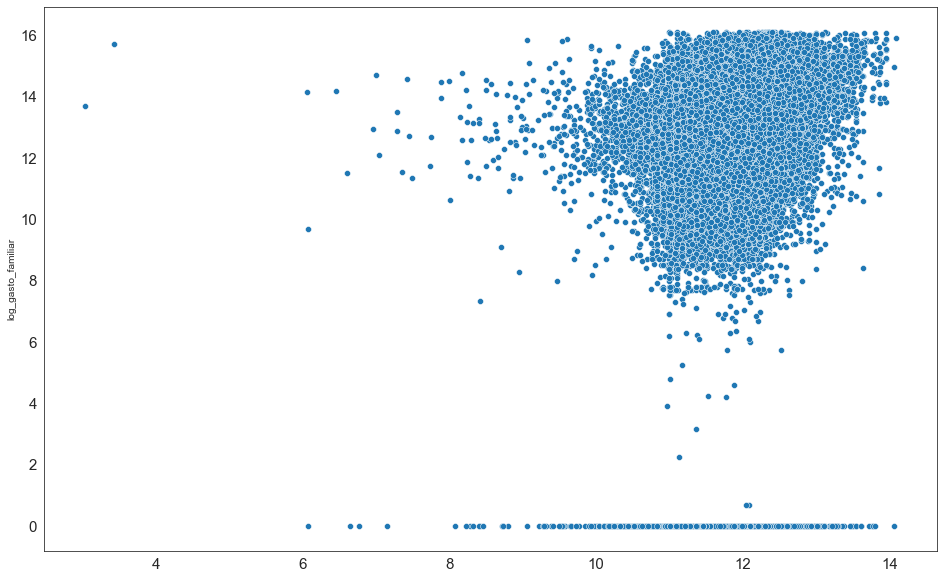

In [352]:
sns.scatterplot(y_pred, y_test)

In [75]:
from sklearn.neural_network import MLPRegressor

In [76]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [77]:
nn_predictions = regr.predict(X_test)
mean_absolute_percentage_error(nn_predictions, y_test)

3.7987137491026854

# GLM

In [87]:
fe_dataframe.modeling_dataframe[glm_features].isnull().sum()

ingreso_final                     0
ingreso_calculado                 0
cuota_cred_hipot_pct              0
cupo_total_tc                     0
cuota_tarjeta_de_credito_pct      0
cuota_de_consumo_pct              0
cuota_rotativos_pct               0
cuota_libranza_sf_pct             0
genero                            0
cuota_de_sector_solidario_pct     0
cuota_sector_real_comercio_pct    0
ind_mora_vigente                  0
ind_annio                         0
cuota_tc_bancolombia_pct          0
cupo_tc_mdo                       0
convenio_lib                      0
cant_oblig_tot_sf                 0
edad                              0
estado_civil_DIV                  0
estado_civil_NI                   0
estado_civil_OTRO                 0
estado_civil_SOL                  0
estado_civil_UL                   0
estado_civil_VIU                  0
ind                               0
nro_tot_cuentas                   0
ctas_activas                      0
ingreso_nomina              

In [106]:
# Fit Poisson regression of sat by weight\
glm_feat_formula = [
    'ingreso_corr_log',
    'cuota_cred_hipot_log',
    'cupo_total_tc_log',
    # 'cuota_tarjeta_de_credito_log',
    'cuota_de_consumo_log',
    'edad',
    # 'genero',
    'cuota_tc_bancolombia_log',
    'ind_annio',
    # 'cupo_tc_mdo_log',
   # 'edad:ingreso_corr',
   # 'edad*cuota_cred_hipot_log',
   #  'genero:ingreso_corr',
    'obl_total_pct',
    'ingreso_geo_alto',
    'ingreso_cero',
    'es_ciudad_principal'
]
glm_formula = 'np.log(gasto_familiar+1) ~ ' + ' + '.join(feature_cols)
glm_features = feature_cols + ['gasto_familiar']
glm_data = fe_dataframe.modeling_dataframe[glm_features]
# glm_data = glm_data[glm_data['gasto_familiar'] < 10000000]
model = glm( glm_formula, data = glm_data,
            family = sm.families.Poisson()).fit()

# Display model results
print(model.summary())

                     Generalized Linear Model Regression Results                      
Dep. Variable:     np.log(gasto_familiar + 1)   No. Observations:                78875
Model:                                    GLM   Df Residuals:                    78858
Model Family:                         Poisson   Df Model:                           16
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:            -2.0000e+05
Date:                        Wed, 20 Jan 2021   Deviance:                       56226.
Time:                                17:37:25   Pearson chi2:                 3.06e+04
No. Iterations:                             4                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

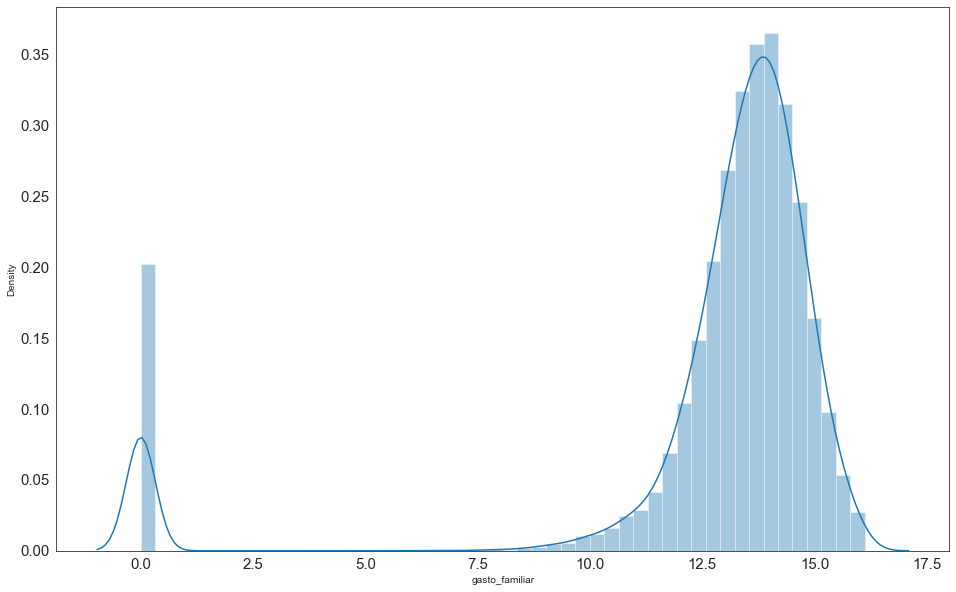

In [295]:
sns.distplot(np.log(glm_data['gasto_familiar']+1))

In [133]:
glm_data.describe(include='all')

,ingreso_final,ingreso_calculado,cuota_cred_hipot_pct,cupo_total_tc,cuota_tarjeta_de_credito_pct,cuota_de_consumo_pct,cuota_rotativos_pct,cuota_libranza_sf_pct,genero,cuota_de_sector_solidario_pct,...,ingreso_segurida_social,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H,rep_calif_cred_NApl,gasto_familiar
count,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,...,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000,1013400.00000
mean,14.76997,2001145.57726,0.02100,6.00252,0.10404,0.19464,0.00570,0.02850,0.49557,0.01854,...,4.05077,0.13744,0.13861,0.11183,0.06993,0.04012,0.11104,0.09627,0.09490,765522.03685
std,1.56519,3777353.15946,0.14252,7.63325,0.47243,2.41957,0.30507,0.50487,0.49998,0.59299,...,6.53894,0.34431,0.34554,0.31516,0.25503,0.19624,0.31418,0.29496,0.29308,1058623.99122
min,0.00000,0.00000,-0.43312,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,14.26020,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,180354.00000
50%,14.79485,807503.00000,0.00000,0.00000,0.02056,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,426113.00000
75%,15.39770,2719204.50000,0.00000,15.29712,0.11120,0.14480,0.00000,0.00000,1.00000,0.00000,...,13.62691,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,910449.10500
max,21.18475,381096170.00000,62.76979,20.10337,137.49425,1017.77375,283.65719,117.11432,1.00000,301.53884,...,19.06253,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,9999293.00000


In [332]:
glm_predictions = model.predict(fe_dataframe.modeling_dataframe[glm_features])

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

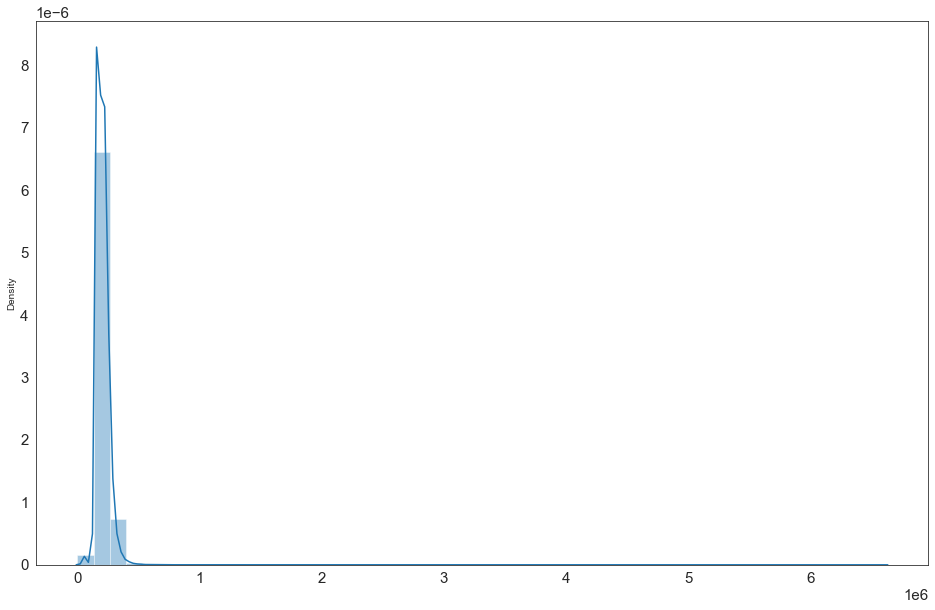

In [151]:
exp_prediction = np.exp(glm_predictions) - 1
sns.distplot(exp_prediction[exp_prediction < 10000000])

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future vers

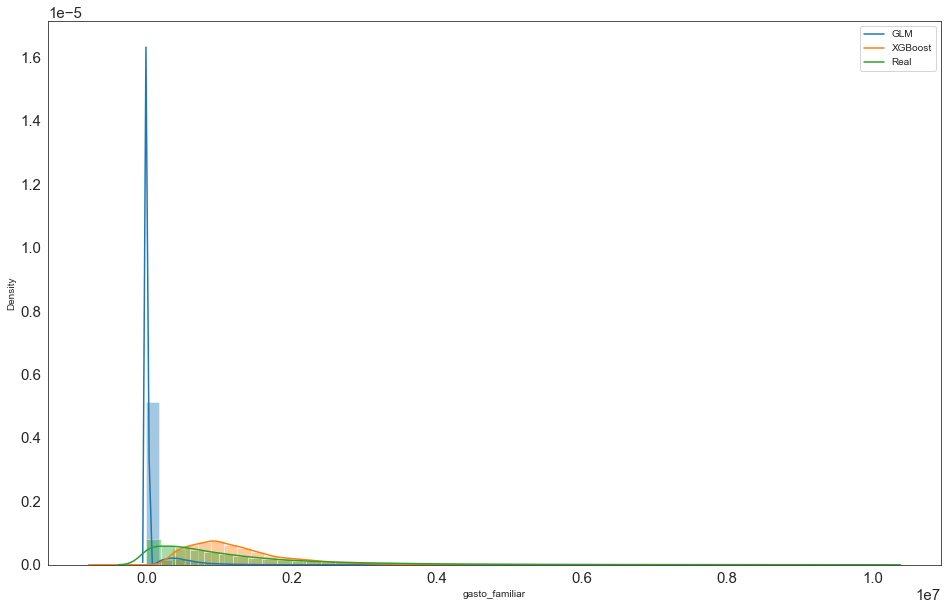

In [334]:
sns.distplot(final_predictions_glm[final_predictions_glm <  10000000])
sns.distplot(y_pred)
sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])
plt.legend(['GLM', "XGBoost", "Real"])

# DL model

In [150]:
nn_model = Sequential()
nn_model.add(Dense(30, activation = 'relu', input_shape = (X.shape[1],))) #Primera capa oculta, justo después de la capa input de 3 variables
nn_model.add(Dropout(0.2))
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer = 'adam', loss = 'mse')
nn_model.fit(X_train, y_train, epochs=20)

Epoch 1/20
3355/3355 [==============================] - 5s 1ms/step - loss: 38.2824
Epoch 2/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.7941
Epoch 3/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4961
Epoch 4/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.8006
Epoch 5/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.6510
Epoch 6/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3454
Epoch 7/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5507
Epoch 8/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4897
Epoch 9/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5531
Epoch 10/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5549
Epoch 11/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3447
Epoch 12/20
3355/3355 [==============================] - 4s 1ms/step - los

In [87]:
nn_predictions = nn_model.predict(X_test)
mean_absolute_percentage_error(nn_predictions, y_test)

0.8384442947941376

# test

In [26]:
test_df = pd.read_csv("test_cleaned.csv").drop("Unnamed: 0", axis=1)
test_df

,id_registro,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,...,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social
0,4055#201902,201902,4055,46,M,CAS,20180807,N,ANTIOQUIA,NApl,...,282500.00000,19000.00000,127148000.00000,1797000.00000,7,2060457.20000,A,S,2734528.00000,0.00000
1,12598#201902,201902,12598,43,M,SOL,20180130,N,CUNDINAMARCA,Entre 0 y 30 dias,...,0.00000,0.00000,87661000.00000,0.00000,5,-71874365.80000,H,S,2291070.00000,0.00000
2,23697#201902,201902,23697,45,M,CAS,20190110,N,BOGOTA D.C.,Entre 0 y 30 dias,...,33000.00000,33000.00000,58967000.00000,0.00000,3,-1448765.30000,A,S,0.00000,0.00000
3,23768#201902,201902,23768,58,M,NI,20180208,N,BOGOTA D.C.,NApl,...,0.00000,0.00000,0.00000,0.00000,0,2208260.39000,G,S,0.00000,0.00000
4,7174#201902,201902,7174,52,F,DIV,20180825,N,BOGOTA D.C.,Entre 0 y 30 dias,...,4088500.00000,11000.00000,22746000.00000,0.00000,7,3212635.74000,A,S,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281661,8596193#202011,202011,8596193,47,F,SOL,20201010,N,ANTIOQUIA,Entre 0 y 30 dias,...,0.00000,0.00000,0.00000,0.00000,2,2101424.08500,A,S,2281362.50000,3876343.00000
281662,8616083#202011,202011,8616083,35,M,NI,20201003,N,BOGOTA D.C.,Entre 0 y 30 dias,...,8286666.66700,237000.00000,99000.00000,0.00000,12,11705497.77500,C,S,14510896.00000,0.00000
281663,8670207#202011,202011,8670207,47,M,DIV,20200616,N,CUNDINAMARCA,Entre 0 y 30 dias,...,30917000.00000,10350000.00000,300000.00000,0.00000,17,-41547904.85000,D,S,0.00000,0.00000
281664,8677655#202011,202011,8677655,42,F,CAS,20200423,N,ANTIOQUIA,Entre 0 y 30 dias,...,37608666.66700,1953000.00000,184811000.00000,0.00000,18,5313457.01250,B,S,11401109.00000,14481371.00000


In [59]:
final_prediction

0         661604.40069
1         985983.87458
2         897955.95914
3         347347.60933
4         682651.64371
              ...     
281661    454408.37963
281662   1171165.12779
281663   2991076.58477
281664   1017050.63458
281665    711716.64829
Length: 281666, dtype: float64

In [76]:
final_predictions_nn.reshape(-1,).shape

(281666,)

In [72]:
final_predictions_xgb.shape

(281666,)

In [88]:
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()
#final_prediction_cat = cat_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])

In [183]:
final_predictions_xgb_log=np.exp(xgb_reg_log.predict(test_df_modeling.modeling_dataframe[feature_cols]))-1
final_predictions_xgb=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
final_predictions_glm=np.exp(model.predict(test_df_modeling.modeling_dataframe[feature_cols]))-1
final_predictions_nn=nn_model.predict(test_df_modeling.modeling_dataframe[feature_cols])                  
final_prediction = final_predictions_glm*0.25 + final_predictions_xgb*0.25 + \
                   final_predictions_nn.reshape(-1,)*0.25 + final_predictions_xgb_log*0.25

In [139]:
xgb_train=xgb_reg.predict(X_test)
nn_train=nn_model.predict(X_test)
glm_train = np.exp(model.predict(X_test))-1
ensemble_score= xgb_train*0.5 + glm_train*0.0 + nn_train.reshape(-1,)*0.5
mean_absolute_percentage_error(ensemble_score, y_test)

0.9999746524016796

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

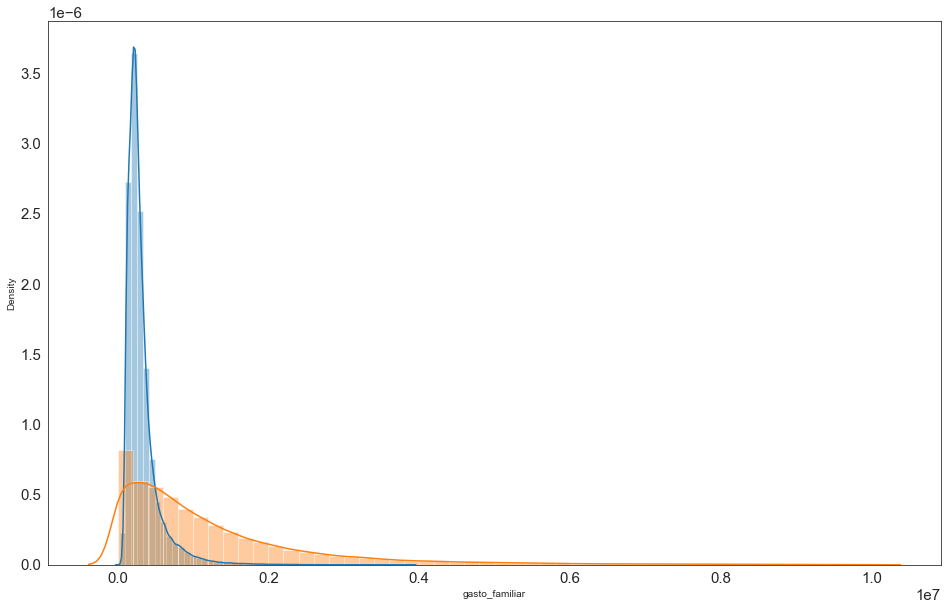

In [184]:
sns.distplot(final_prediction[final_prediction < 10000000])
#sns.distplot(final_predictions_nn[final_predictions_nn < 10000000])
sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])
#sns.distplot(y_test)

In [185]:
submission = pd.concat([test_df['id_registro'],pd.Series(final_prediction)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
submission

,id_registro,gasto_familiar
0,4055#201902,254486.45140
1,12598#201902,269680.37080
2,23697#201902,323651.26380
3,23768#201902,216778.38190
4,7174#201902,369292.42640
...,...,...
281661,8596193#202011,301050.72020
281662,8616083#202011,640165.57000
281663,8670207#202011,1589629.13130
281664,8677655#202011,502436.08200


In [92]:
class PrepareSubmission:
    
    def __init__(self, dataframe, model):
        self.test_dataframe = dataframe
        self.model = model
     
    def makePrediction(self, dataframe)
        test_df_modeling = DataFramePreProcessor(test_df, test=True)
        test_df_modeling.process()
        final_predictions=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
    
    
    def prepareSubmissionDF(self, dataframe):
        submission = pd.concat([test_df['id_registro'],pd.Series(final_predictions)], axis=1)
        submission.columns = ["id_registro", "gasto_familiar"]
    
    
    def submit(self):
        submission.to_csv("submission_underground.csv", index=False)

In [186]:
submission.to_csv("submission_underground.csv", index=False)

In [349]:
final_prediction[final_prediction < 0]

32        -49577.95957
37        -31132.87461
62        -53999.65246
87        -84479.18775
107       -13693.60451
              ...     
281250   -157127.52459
281302     -9315.22841
281462    -12892.82637
281547    -16814.90453
281553    -13733.63068
Length: 8545, dtype: float64

# Compare predictions


In [37]:
best_submission = pd.read_csv("submission_underground XGboost + ElasticNET.csv")
best_submission_2 =  pd.read_csv("submission_underground XGBoost+17meses+Boxcox+Log.csv")


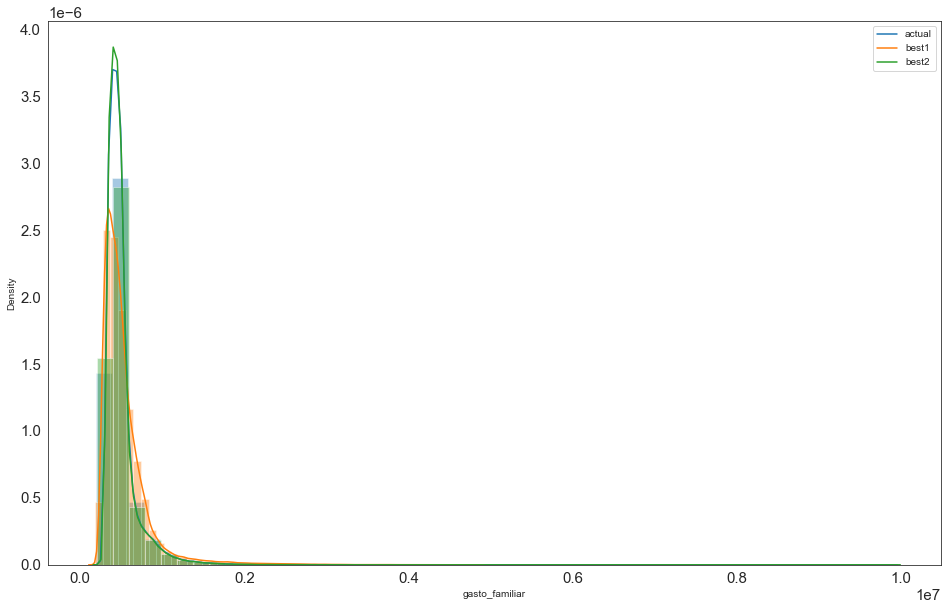

In [38]:
sns.distplot(submission['gasto_familiar'])
#sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])

sns.distplot(best_submission_2[best_submission_2['gasto_familiar'] < 10000000]['gasto_familiar'])
sns.distplot(best_submission[best_submission['gasto_familiar'] < 10000000]['gasto_familiar'])

plt.legend(['actual', 'best1', 'best2'])

In [158]:
submission['gasto_familiar'].describe()

count       281666.00000
mean     155788352.00000
std      247654896.00000
min       30600224.00000
25%       53182301.00000
50%       87256896.00000
75%      161703112.00000
max     2594839808.00000
Name: gasto_familiar, dtype: float64